# CS 4770 Lab 1 Part B
##### Connor Penrod / cfpvf9 / 12506508

Here's the full source code for the MLP

In [1]:
import math
import csv
import random
from pprint import pprint
import sys
import copy
import matplotlib.pyplot as plt

#test targets for debugging
#test_targets = [[0,1]] * 400

def activation_function(x):
    return 1/(1 + math.exp(-x))
def deriv_activation_function(x):
    return activation_function(x)*(1-activation_function(x))
#begin multilayer perceptron
class ThreeLayerPerceptron(object):

    def __init__(self, _input_count, _hidden_count, _output_count, _samples, 
                    _targets, _init_weights1, _init_weights2, _init_bias1, _init_bias2,
                    _learning_rate, _momentum):
        self.input_node_count = _input_count
        self.hidden_node_count = _hidden_count
        self.output_node_count = _output_count

        self.samples = copy.deepcopy(_samples)
        self.w_layer1 = copy.deepcopy(_init_weights1)
        self.w_layer2 = copy.deepcopy(_init_weights2)
        self.dw_layer1 = [[0] * self.input_node_count] * (self.hidden_node_count+1)
        self.dw_layer2 = [[0] * self.hidden_node_count] * (self.output_node_count+1)
        self.hidden_layer_bias = copy.deepcopy(_init_bias1)
        self.output_layer_bias = copy.deepcopy(_init_bias2)
        self.targets = copy.deepcopy(_targets)
        self.learning_rate = _learning_rate
        self.momentum = _momentum
        self.errors = []
        self.target_error = 0.001
        self.sumofsqrerrors = []
    
    def initializeWeights(self):
        #initializes all weights and biases to random values between -1 and 1
        self.w_layer1 = [[random.uniform(-1,1) for i in range(self.input_node_count)]] * self.hidden_node_count
        self.w_layer2 = [[random.uniform(-1,1) for i in range(self.hidden_node_count)]] * self.output_node_count
        self.hidden_layer_bias = [random.uniform(-1,1) for i in range(self.hidden_node_count)]
        self.output_layer_bias = [random.uniform(-1,1) for i in range(self.output_node_count)]
    
    def setData(self, newData, newTargets):
        #sets the data of an MLP that's already been created
        self.samples = copy.deepcopy(newData)
        self.targets = copy.deepcopy(newTargets)
        
    def train(self, target_error, suppress_output=False):
        if not suppress_output:
            print() #used for output formatting
        self.target_error = target_error
        self.sumofsqrerrors = []
        prevSumSqr = 0
        currSumSqr = float('infinity')
        epochCount = 1
        while abs(prevSumSqr-currSumSqr) > self.target_error: #run through until sum sqr errors difference is low enough
        # for each epoch, loop through all self.samples
            if not suppress_output:
                print("Training epoch #" + str(epochCount), end='\r')
            epochCount += 1
            prevSumSqr = currSumSqr
            self.errors = []
            for k in range(len(self.samples)):
                hidden_layer_aggregation = []
                output_layer_aggregation = []
                hidden_layer_outputs = []
                output_layer_outputs = []
                output_layer_errors = []
                
                # compute aggregate values for input -> hidden layer
                for currentHiddenNode in range(self.hidden_node_count):
                    aggregate = 0
                    for weight in range(len(self.w_layer1[currentHiddenNode])):
                        aggregate += (self.samples[k][weight] * self.w_layer1[currentHiddenNode][weight])
                    aggregate += self.hidden_layer_bias[currentHiddenNode]
                    hidden_layer_aggregation.append(aggregate)
                    
                # find hidden layer outputs
                for aggregateIdx in range(self.hidden_node_count):
                    output = activation_function(hidden_layer_aggregation[aggregateIdx])
                    hidden_layer_outputs.append(output)
                
                # compute aggregate values for hidden -> output layer
                for currentOutputNode in range(self.output_node_count):
                    aggregate = 0
                    for weight in range(len(self.w_layer2[currentOutputNode])):
                        aggregate += (hidden_layer_outputs[weight] * self.w_layer2[currentOutputNode][weight])
                    aggregate += self.output_layer_bias[currentOutputNode]
                    output_layer_aggregation.append(aggregate)
                    
                # find output layer outputs
                for aggregateIdx in range(self.output_node_count):
                    output = activation_function(output_layer_aggregation[aggregateIdx])
                    output_layer_outputs.append(output)
                        
                # forward pass done, begin backpropagation   
                curr_w_layer2 = copy.deepcopy(self.w_layer2) #copies current weights for use in hidden layer backpropagation
                # start at output neurons, compute weight changes and new weights for weight layer 2
                for output_neuron in range(self.output_node_count):
                    dw_entry = [] #stores the previous weight change
                    e_output = (self.targets[k][output_neuron] - output_layer_outputs[output_neuron]) #calculates output node error
                    output_layer_errors.append(e_output) #stores error for hidden layer weight change calculation
                    self.errors.append(e_output)
                    output_activation_deriv = deriv_activation_function(output_layer_aggregation[output_neuron]) #calculates the output layer aggregates 
                                                                                                                 #put through the derivative of the sigmoid
                    for weight in range(len(self.w_layer2[output_neuron])): #for each weight in the layer 2
                        dw = -self.learning_rate * -e_output * output_activation_deriv * hidden_layer_outputs[weight] #calculate change in weight
                        self.w_layer2[output_neuron][weight] += dw + self.momentum * self.dw_layer2[output_neuron][weight] #update weight with dw and self.momentum term
                        dw_entry.append(dw + self.momentum * self.dw_layer2[output_neuron][weight]) #+ self.momentum * self.dw_layer2[output_neuron][weight]) #store previous weight change
                    db = -self.learning_rate * -e_output * output_activation_deriv * 1 #find change in bias
                    self.output_layer_bias[output_neuron] += db + self.momentum*self.dw_layer2[output_neuron][-1] #update bias
                    dw_entry.append(db + self.momentum*self.dw_layer2[output_neuron][-1]) #store bias at the end of self.dw_layer2 array
                    self.dw_layer2[output_neuron] = dw_entry #store the change in weights for use in the next sample
                #compute weight changes for hidden layer
                hidden_layer_errors = []
                for hidden_neuron in range(self.hidden_node_count):
                    dw_entry = []
                    hidden_activation_deriv = deriv_activation_function(hidden_layer_aggregation[hidden_neuron]) #calculates the hidden layer aggregates
                    sum_of_error_propagation = 0 #initialize sum for error propagation
                    for output_neuron in range(self.output_node_count): #for each output node
                        e_output = output_layer_errors[output_neuron] #grab the error for that node
                        deriv_activation_func_output = deriv_activation_function(output_layer_aggregation[output_neuron])
                        
                        #this missing bit from Part A right here was the reason for my trouble in Part A. Fixed now.
                        
                        sum_of_error_propagation += curr_w_layer2[output_neuron][hidden_neuron] * deriv_activation_func_output * e_output
                    for weight in range(len(self.w_layer1[hidden_neuron])): #for each weight in layer 1
                        dw = -self.learning_rate * -sum_of_error_propagation * self.samples[k][weight] * hidden_activation_deriv #find change in weight
                        self.w_layer1[hidden_neuron][weight] += dw + self.momentum * self.dw_layer1[hidden_neuron][weight] #update that weight
                        dw_entry.append(dw + self.momentum*self.dw_layer1[hidden_neuron][weight])
                    db = -self.learning_rate * -sum_of_error_propagation * 1 * hidden_activation_deriv #find change in bias
                    self.hidden_layer_bias[hidden_neuron] += db + self.momentum*self.dw_layer1[hidden_neuron][-1] #update bias (bias is tacked onto the end of the self.dw_layer1 array)
                    dw_entry.append(db + self.momentum*self.dw_layer1[hidden_neuron][-1]) #change in bias is held in the self.dw_layer1 array 
                    self.dw_layer1[hidden_neuron] = dw_entry #save the change in weight for the self.momentum of next sample
                                
            s = 0 #calculate and print sum of sqr errors for total epoch
            for e in self.errors:
                s += e*e
            currSumSqr = s
            self.sumofsqrerrors.append(s)
            
            #this section randomizes the data and the targets together to keep them in order relative to eachother
            c = list(zip(self.samples, self.targets))
            random.shuffle(c)
            self.samples, self.targets = zip(*c)
         
        if not suppress_output:
            print("Reached convergence with learning rate = " + str(self.learning_rate) + " and target error difference = " + str(self.target_error) + " after " + str(epochCount) + " epochs.", end='\r')
            print()
        return self.sumofsqrerrors
        
    def classify(self, data):
        #runs only the forward pass to classify the given data
        outputs = []
        for k in range(len(data)):
            hidden_layer_aggregation = []
            output_layer_aggregation = []
            hidden_layer_outputs = []
            output_layer_outputs = []
            output_layer_errors = []

            # compute aggregate values for input -> hidden layer
            for currentHiddenNode in range(self.hidden_node_count):
                aggregate = 0
                for weight in range(len(self.w_layer1[currentHiddenNode])):
                    aggregate += (data[k][weight] * self.w_layer1[currentHiddenNode][weight])
                aggregate += self.hidden_layer_bias[currentHiddenNode]
                hidden_layer_aggregation.append(aggregate)

            # find hidden layer outputs
            for aggregateIdx in range(self.hidden_node_count):
                output = activation_function(hidden_layer_aggregation[aggregateIdx])
                hidden_layer_outputs.append(output)

            # compute aggregate values for hidden -> output layer
            for currentOutputNode in range(self.output_node_count):
                aggregate = 0
                for weight in range(len(self.w_layer2[currentOutputNode])):
                    aggregate += (hidden_layer_outputs[weight] * self.w_layer2[currentOutputNode][weight])
                aggregate += self.output_layer_bias[currentOutputNode]
                output_layer_aggregation.append(aggregate)

            # find output layer outputs
            for aggregateIdx in range(self.output_node_count):
                output = activation_function(output_layer_aggregation[aggregateIdx])
                output_layer_outputs.append(output)
            outputs.append((output_layer_outputs[0])) #only returns back one of the outputs threshholded to 0 or 1
        return outputs


First we'll read in the data from the given input files

In [2]:
samples = []
targets = []
w_layer1 = []
w_layer2 = []
hidden_layer_bias = []
output_layer_bias = []

#handles file input
with open('C:\\Users\\Conno\\Classes\\CS_CompIntelligence\\Lab1\\cross_data (3 inputs - 2 outputs).csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        entry = []
        targetSet = []
        for i in range(len(row)):
            if i < len(row) - 2:
                entry.append(float(row[i]))
            else:
                targetSet.append(float(row[i]))
        samples.append(entry)
        targets.append(targetSet)
with open('C:\\Users\\Conno\\Classes\\CS_CompIntelligence\\Lab1\\w1 (3 inputs - 11 nodes).csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        entry = []
        for i in range(len(row)):
            entry.append(float(row[i]))
        w_layer1.append(entry)
with open("C:\\Users\\Conno\\Classes\\CS_CompIntelligence\\Lab1\\w2 (from 11 to 2).csv") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        entry = []
        for i in range(len(row)):
            entry.append(float(row[i]))
        w_layer2.append(entry)
with open("C:\\Users\\Conno\\Classes\\CS_CompIntelligence\\Lab1\\b1 (11 nodes).csv") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        entry = float(row[0])
        hidden_layer_bias.append(entry)
with open("C:\\Users\\Conno\\Classes\\CS_CompIntelligence\\Lab1\\b2 (2 output nodes).csv") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        entry = float(row[0])
        output_layer_bias.append(entry)


(1) Now we create a 3:11:2 perceptron and train it until it reaches convergence (defined as sum-of-squared-error diff. less than 0.001) with the given input data

In [3]:
perceptron = ThreeLayerPerceptron(3, 11, 2, samples, targets, w_layer1, w_layer2,
                                hidden_layer_bias, output_layer_bias, _learning_rate = 0.7, _momentum = 0.3)
sqr_errors = list(map(round,perceptron.train(target_error = 0.001)))


Reached convergence with learning rate = 0.7 and target error difference = 0.001 after 133 epochs.


Here's the plot of the results

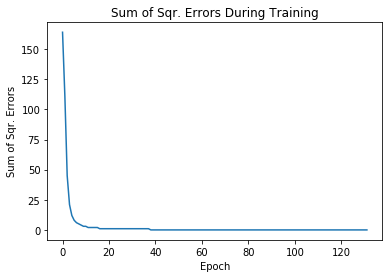

In [4]:
plt.plot(sqr_errors)
plt.xlabel("Epoch")
plt.ylabel("Sum of Sqr. Errors")
plt.title("Sum of Sqr. Errors During Training")
plt.show()

We'll create a sample of all values between [-2.1, -2.1] and [2.1, 2.1] at 0.01 intervals

In [5]:
interval = 0.01
count = round(2.1/interval)
test_samples = [[0,0,0]] * ((count*2)*(count*2))
currIdx = 0
for i in range(-count,count):
    for j in range(-count,count):
        test_samples[currIdx] = [i*interval, j*interval, random.uniform(-0.001, 0.001)]
        currIdx += 1
    

Classify those samples. `test_outputs` will contain the output from one output neuron (value from [0,1])

In [6]:
test_outputs = perceptron.classify(test_samples)

And plot the samples with the z-axis (color) being the output from our MLP

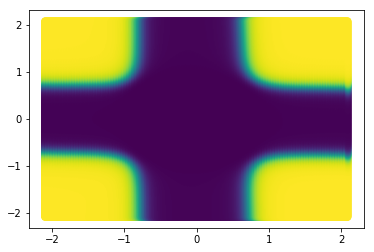

In [7]:
plt.scatter([i[0] for i in test_samples],[i[1] for i in test_samples], c=test_outputs)

The training data is plotted below for reference

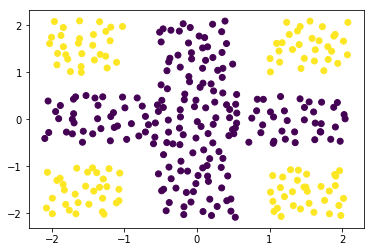

In [8]:
plt.scatter([i[0] for i in samples],[i[1] for i in samples], c=[(i[0]) for i in targets])

(2) Now we'll retrain the network with 3 different learning rates (0.01, 0.2, and 0.9)

In [15]:
perceptron1 = ThreeLayerPerceptron(3, 11, 2, samples, targets, w_layer1, w_layer2,
                                hidden_layer_bias, output_layer_bias, _learning_rate = 0.01, _momentum = 0.3)
perceptron2 = ThreeLayerPerceptron(3, 11, 2, samples, targets, w_layer1, w_layer2,
                                hidden_layer_bias, output_layer_bias, _learning_rate = 0.2, _momentum = 0.3)
perceptron3 = ThreeLayerPerceptron(3, 11, 2, samples, targets, w_layer1, w_layer2,
                                hidden_layer_bias, output_layer_bias, _learning_rate = 0.9, _momentum = 0.3)
sqr_errors1 = perceptron1.train(target_error = 0.001)
sqr_errors2 = perceptron2.train(target_error = 0.001)
sqr_errors3 = perceptron3.train(target_error = 0.001)


Reached convergence with learning rate = 0.01 and target error difference = 0.001 after 1455 epochs.

Reached convergence with learning rate = 0.2 and target error difference = 0.001 after 256 epochs.

Reached convergence with learning rate = 0.9 and target error difference = 0.001 after 116 epochs.


Here's all 4 perceptrons' sum-of-square-errors plotted

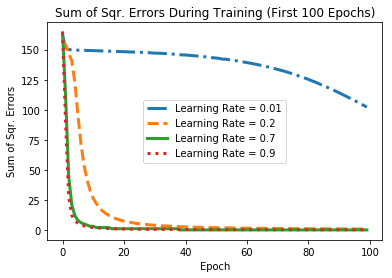

In [19]:
plt.plot(sqr_errors1[:min(100, len(sqr_errors1)-1)], label="Learning Rate = 0.01", linestyle="-.", linewidth=3)
plt.plot(sqr_errors2[:min(100, len(sqr_errors2)-1)], label="Learning Rate = 0.2", linestyle="--", linewidth=3)
plt.plot(sqr_errors[:min(100, len(sqr_errors)-1)], label="Learning Rate = 0.7", linestyle="-", linewidth=3)
plt.plot(sqr_errors3[:min(100, len(sqr_errors3)-1)], label="Learning Rate = 0.9", linestyle=":", linewidth=3)
plt.xlabel("Epoch")
plt.ylabel("Sum of Sqr. Errors")
plt.title("Sum of Sqr. Errors During Training (First 100 Epochs)")
plt.legend(loc='best')
plt.show()




#formatting

It's easy to see from the plot above that higher learning rates cause networks to converge faster

(3) Now we'll train two more networks with a learning rate of 0.01 and two momentums of 0 and 0.6

In [11]:
perceptron4 = ThreeLayerPerceptron(3, 11, 2, samples, targets, w_layer1, w_layer2,
                                hidden_layer_bias, output_layer_bias, _learning_rate = 0.01, _momentum = 0)
perceptron5 = ThreeLayerPerceptron(3, 11, 2, samples, targets, w_layer1, w_layer2,
                                hidden_layer_bias, output_layer_bias, _learning_rate = 0.01, _momentum = 0.6)
sqr_errors4 = perceptron4.train(target_error = 0.001)
sqr_errors5 = perceptron5.train(target_error = 0.001)


Reached convergence with learning rate = 0.01 and target error difference = 0.001 after 1812 epochs.

Reached convergence with learning rate = 0.01 and target error difference = 0.001 after 1008 epochs.


And plot these two together

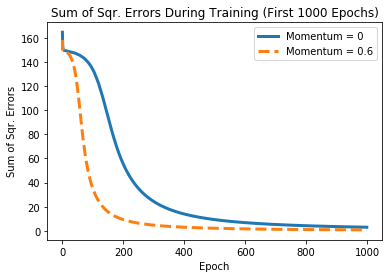

In [16]:
plt.plot(sqr_errors4[:min(1000, len(sqr_errors4)-1)], label="Momentum = 0", linestyle="-", linewidth=3)
plt.plot(sqr_errors5[:min(1000, len(sqr_errors5)-1)], label="Momentum = 0.6", linestyle="--", linewidth=3)
plt.xlabel("Epoch")
plt.ylabel("Sum of Sqr. Errors")
plt.title("Sum of Sqr. Errors During Training (First 1000 Epochs)")
plt.legend(loc='best')
plt.show()

(4) Finally, we'll create a 4:8:2 MLP, 4:10:2 MLP, and 4:4:2 MLP, and perform 5-fold cross-validation on them with learning rate = 0.5 and momentum = 0.3

In [13]:
gaussian_data = []
gaussian_targets = []
with open('C:\\Users\\Conno\\Classes\\CS_CompIntelligence\\Lab1\\Two_Class_FourDGaussians500.txt') as f:
    for line in f:
        row = list(map(float, line.split()))
        entry = []
        targetSet = []
        for i in range(len(row)):
            if i < len(row) - 1:
                entry.append(float(row[i]))
            else:
                targetSet.append(float(row[i]) - 1)
        targetSet.append(float(0) if targetSet[0]-1 > 0 else float(1))
        gaussian_data.append(entry)
        gaussian_targets.append(targetSet)

gaussian_data_class1 = gaussian_data[:500]
gaussian_data_class2 = gaussian_data[500:]
gaussian_targets_class1 = gaussian_targets[:500]
gaussian_targets_class2 = gaussian_targets[500:]

folds_data = {}
folds_targets = {}
for i in range(1,6):
    folds_data[i] = copy.deepcopy(gaussian_data_class1)[:100]
    folds_data[i].extend(copy.deepcopy(gaussian_data_class2)[:100])
    folds_targets[i] = copy.deepcopy(gaussian_targets_class1[:100])
    folds_targets[i].extend(copy.deepcopy(gaussian_targets_class2)[:100])

def FiveFoldValidation(gaussian_perceptron, flag=False):
    confusion_matrices = []
    configs = [[2,3,4,5],[1,3,4,5],[1,2,4,5],[1,2,3,5],[1,2,3,4]]
    missing = [1,2,3,4,5]
    for configInd in range(len(configs)):
        trainingData = []
        trainingTargets = []
        for ind in configs[configInd]:
            trainingData += folds_data[ind]
            trainingTargets += folds_targets[ind]
        gaussian_perceptron.initializeWeights()
        gaussian_perceptron.setData(trainingData, trainingTargets)
        gaussian_sqr_errors = gaussian_perceptron.train(0.01, True)
        gaussian_outputs = gaussian_perceptron.classify(folds_data[missing[configInd]])

        true_pFunc = lambda x, y : True if x == 1 and y == 1 else False
        false_pFunc = lambda x, y : True if x == 1 and y == 0 else False
        true_nFunc = lambda x, y : True if x == 0 and y == 0 else False
        false_nFunc = lambda x, y : True if x == 0 and y == 1 else False

        true_positives_list = list(map(true_pFunc, list(map(lambda x : int(round(x)),gaussian_outputs)), list(map(lambda x : int(x[0]), folds_targets[missing[configInd]]))))
        false_positives_list = list(map(false_pFunc, list(map(lambda x : int(round(x)),gaussian_outputs)), list(map(lambda x : int(x[0]), folds_targets[missing[configInd]]))))
        true_negatives_list = list(map(true_nFunc, list(map(lambda x : int(round(x)),gaussian_outputs)), list(map(lambda x : int(x[0]), folds_targets[missing[configInd]]))))
        false_negatives_list = list(map(false_nFunc, list(map(lambda x : int(round(x)),gaussian_outputs)), list(map(lambda x : int(x[0]), folds_targets[missing[configInd]]))))

        true_positives = sum(true_positives_list)
        false_positives = sum(false_positives_list)
        true_negatives = sum(true_negatives_list)
        false_negatives = sum(false_negatives_list)

        confusion_matrix = [
            [true_positives, false_positives],
            [false_negatives, true_negatives]
        ]

        if flag:
            print("\nConfusion matrix for fold " + str(configInd+1))
            print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in confusion_matrix]))

        confusion_matrices.append(confusion_matrix)
    aggregate_matrix = [[0,0],[0,0]]
    for matrix in confusion_matrices:
        aggregate_matrix[0][0] += matrix[0][0]
        aggregate_matrix[0][1] += matrix[0][1]
        aggregate_matrix[1][0] += matrix[1][0]
        aggregate_matrix[1][1] += matrix[1][1]
    aggregate_matrix[0][0] = aggregate_matrix[0][0]/len(confusion_matrices)
    aggregate_matrix[0][1] = aggregate_matrix[0][1]/len(confusion_matrices)
    aggregate_matrix[1][0] = aggregate_matrix[1][0]/len(confusion_matrices)
    aggregate_matrix[1][1] = aggregate_matrix[1][1]/len(confusion_matrices)  

    print("\nAggregate confusion matrix for this MLP")
    print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in aggregate_matrix]))
    print()

gaussian_perceptron1 = ThreeLayerPerceptron(4, 8, 2, None, None, None, None,
                                None, None, _learning_rate = 0.5, _momentum = 0.3)
gaussian_perceptron2 = ThreeLayerPerceptron(4, 10, 2, None, None, None, None,
                                None, None, _learning_rate = 0.5, _momentum = 0.3)
gaussian_perceptron3 = ThreeLayerPerceptron(4, 2, 2, None, None, None, None,
                                None, None, _learning_rate = 0.5, _momentum = 0.3)

print("5-fold validation on 4:8:2 MLP:")
FiveFoldValidation(gaussian_perceptron1, True)
print("5-fold validation on 4:10:2 MLP:")
FiveFoldValidation(gaussian_perceptron2)
print("5-fold validation on 4:2:2 MLP:")
FiveFoldValidation(gaussian_perceptron3)

#gaussian_sqr1 = perceptron.train(target_error = 0.01)

5-fold validation on 4:8:2 MLP:

Confusion matrix for fold 1
99	7
1	93

Confusion matrix for fold 2
99	9
1	91

Confusion matrix for fold 3
99	10
1	90

Confusion matrix for fold 4
98	7
2	93

Confusion matrix for fold 5
97	7
3	93

Aggregate confusion matrix for this MLP
98.4	8.0
1.6	92.0

5-fold validation on 4:10:2 MLP:

Aggregate confusion matrix for this MLP
99.0	8.4
1.0	91.6

5-fold validation on 4:2:2 MLP:

Aggregate confusion matrix for this MLP
99.0	7.6
1.0	92.4

